In [1]:
from contextlib import redirect_stdout # For printing our files
import os # OS File system utilization in printing files
import pandas as pd #Manipulating our data frames
import numpy as np #Utilizing numpy commands

In [2]:
#Code made by Paul Williamson/KB5MU with very small edits by me - much thanks!
uba_folder = '' #format for your github repo where needed
uba_extension = ".uba"
output_extension = "_summmary.txt"

for filename in os.listdir(uba_folder):
    if filename.endswith(uba_extension):
        with open(os.path.join(uba_folder, filename), 'r', encoding='cp1252') as f:
            with open(filename+output_extension, 'w') as outf:
                print(filename)
                at_messages = False
                for line in f:
                    if line.strip() == "<Messages>":
                        at_messages = True
                    if at_messages:
                        print(line.strip(), file=outf)

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [2]:
# As a conscious choice, we have chosen not to attempt to automate this process because of the potential difficulty costing more time than sorting each .uba summary.txt manually. 
# However, if wanted, you can attempt to automate this process. In this experiment however, we have sorted each file into their corresponding file types manually. 
# In doing so, here are our results.
# We found that each file contains two identifiable markers that signify the start of the discharge and the start of the long 3 hour equalization charge. 
# We are generally able to tell which file has what amount of cycles because of this. 
# IN CASE We want to utilize later cycles of the batteries, we can only use sixgroup. However, all other files have at least one cycle to use, so we can utilize all of the files for the first cycle analysis.
# 1HDC = 1 Hour Dis-Charge
# 3HEC = 3 Hour Equalization Charge
#1HDC, 3HEC, 1HDC
threegroup = [19, 20, 83, 84]

#1HDC, 3HEC, 1HDC, 3HEC
fourgroup = [6, 4, 3, 2, 1]

#1HDC, 3HEC, 1HDC, 3HEC, 1HDC
fivegroup = [95, 96, 94, 93, 65, 54, 53, 31, 30, 29, 15]

#1HDC, 3HEC, 1HDC, 3HEC, 1HDC, 3HEC
sixgroup = [91, 89, 88, 87, 86, 85, 80, 79, 78, 77, 74, 73, 72, 71, 66, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 52, 51, 50, 49, 46, 45, 42, 41, 40, 39, 38, 37, 36, 35, 34, 32, 28, 26, 25, 21, 22, 21, 18, 17, 16,  14, 13]


In [3]:
trurange = list(range(1,69))+list(range(83,99)) # After iterating through which files exist, we have created a range of all possible useable files.
file = {} # Create a dictionary to store our formatted and read files
dischargestart = 'Finish=MaxChargeC' # Start of the discharge cycle, graphed as a plateau in the data
chargestart = 'Finish=CutoffV' # End of the discharge cycle, start of the charge cycle, graphed as a trough in the data
split = 'Finish=MaxDischargeTime' # Split halfway through the charge cycle as current increases, appears as the point where the charge cycle changes.
end = 'Finish=UserRequest:Stop' # End of the data file

In [7]:
for x in trurange:
    try:
        file[x] =(
             pd.read_csv(
                f'NiCd - Key Lime #{x}(data).csv', 
                skip_blank_lines=False, #We want all index numbers to stay the same
                keep_default_na=True, #We want to keep all of our N/A values for the same reason
                names=['Time', 'Volt', 'M/A', 'C', 'Sig'],
            )
        )
    except:
        print(f'fail in {x}')

In [9]:
locsigdc = {} #first true discharge positional location
locsigch = {} #first true charge positional location
locsigsp = {} #first true split positional location
locsigend = {} #end of the the first charge cycle
for x in file.keys(): 
    if len(file[x].loc[file[x]['Sig'] == dischargestart].index.tolist()) >=3:
        if len(file[x].loc[file[x]['Sig'] == chargestart].index.tolist()) >=3:
            if len(file[x].loc[file[x]['Sig'] == split].index.tolist()) >=3:
                if file[x].loc[file[x]['Sig'] == dischargestart].index.tolist()[0]\
                < file[x].loc[file[x]['Sig'] == chargestart].index.tolist()[1]\
                < file[x].loc[file[x]['Sig'] == split].index.tolist()[2]:
                        locsigdc[x] = (file[x].loc[file[x]['Sig'] == dischargestart].index.tolist()[0]) 
                        locsigch[x] = (file[x].loc[file[x]['Sig'] == chargestart].index.tolist()[1])
                        locsigsp[x] = (file[x].loc[file[x]['Sig'] == split].index.tolist()[2])
                        locsigend[x] = (file[x].loc[file[x]['Sig'] == split].index.tolist()[2] + 500)
                


In [11]:
dischargecycle = {} #first discharge
splitchargecycle = {} #first half of the charge cycle
postsplit = {} # last half of the charge cycle
for x in locsigdc.keys(): #We want to see which ones fail this cell, so we will run it through the same keys again.
        try:
            if locsigsp[x] < 3000:
                dischargecycle[x] = file[x]['Volt'].truncate(before=locsigdc[x],
                                                             after=locsigch[x])
                splitchargecycle[x] = file[x]['Volt'].truncate(before=locsigch[x], 
                                                               after=locsigsp[x])
                postsplit[x] = file[x]['Volt'].truncate(before=locsigsp[x],
                                                        after=locsigend[x])
        except:
            print(f'fail in {x}')

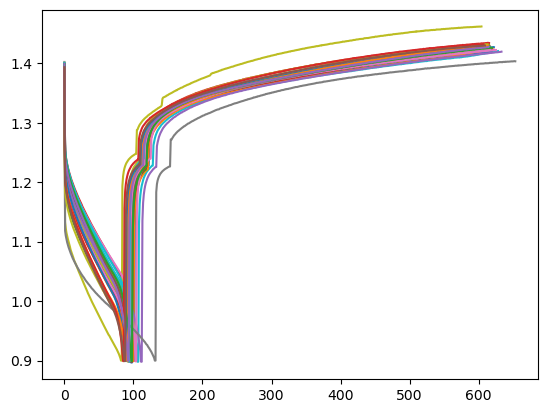

In [13]:
fullcycle = {}
for x in dischargecycle.keys():
    if postsplit[x].max() < 1.5:
        if splitchargecycle[x].max() < 1.3:
            fullcycle[x] = pd.concat([dischargecycle[x].reset_index(drop=True), 
                                     splitchargecycle[x].reset_index(drop=True), 
                                     postsplit[x].reset_index(drop=True)], 
                                    ignore_index=True
                                   )
            fullcycle[x].plot(kind='line')
for x in fullcycle.keys():
    with open(f'FullCycleComparison#{x}.csv', 'w') as f:
        with redirect_stdout(f):
            for y in fullcycle.keys():
                if x>y:
                    if x!=y:
                        print(abs(((fullcycle[x].reset_index(drop=True)).sub(fullcycle[y].reset_index(drop=True))).sum()), f',{x}, ', f'{y}')
tetris={}
for x in fullcycle.keys():
     tetris[x] = pd.read_csv(f'FullCycleComparison#{x}.csv', 
                     names=['Difference', 'File', 'Compared']).drop_duplicates()
del tetris[7]
print(tetris)
with open('FullCycleCollectiveMin.csv', 'w') as f:
    with redirect_stdout(f):
        for x in tetris.keys():
            print(tetris[x].reset_index(drop=True).loc[[tetris[x]['Difference'].reset_index(drop=True).idxmin(0)]].to_csv(index=False, header=False))
emerald = pd.read_csv('FullCycleCollectiveMin.csv', names=['Difference', 'File', 'Compared']).sort_values(by=['Compared'], axis=0, ascending=True, inplace=False)
print(emerald)
emerald.to_csv('FullSorted.csv', header=True, index=False, mode='w')

In [29]:
for x in file.keys(): # Charge CYCLE being used - can be changed to ANY cycle as long as arguments are passed for clarifying data.
    if x in splitchargecycle.keys():
        with open(f'ChargeComparison_of_{x}.csv', 'w') as f:
            with redirect_stdout(f):
                for y in splitchargecycle.keys():
                    if x>y:
                        if x != y:
                            print(abs(((dischargecycle[x].reset_index(drop=True)).sub(dischargecycle[y].reset_index(drop=True))).sum()), 
                                  ',',
                                  abs(((splitchargecycle[x].reset_index(drop=True)).sub(splitchargecycle[y].reset_index(drop=True))).sum()),
                                  ',',
                                  abs((abs(((dischargecycle[x].reset_index(drop=True)).sub(dischargecycle[y].reset_index(drop=True))).sum()))-(abs(((splitchargecycle[x].reset_index(drop=True)).sub(splitchargecycle[y].reset_index(drop=True))).sum()))),
                                  f',{x},', 
                                  f'{y}'
                                 )

In [32]:
gofish={}
for x in splitchargecycle.keys():
     gofish[x] = pd.read_csv(f'ChargeComparison_of_{x}.csv', 
                     names=['DisC_Difference', 'CharDifference', 'DisCharDiff', 'File', 'Compared'])
del gofish[7] # our 7th key is empty

In [34]:
print(gofish[x])

    DisC_Difference  CharDifference  DisCharDiff  File  Compared
0          2.448182        0.140661     2.307521    98         7
1          2.749916        0.032153     2.717763    98         8
2          1.789010        0.093291     1.695719    98         9
3          0.066050        0.134016     0.067966    98        10
4          1.791430        0.093760     1.697670    98        11
5          7.951170        0.175386     7.775784    98        12
6          2.373500        0.175893     2.197607    98        13
7          3.030436        0.068014     2.962422    98        14
8          3.069108        0.035082     3.034026    98        15
9          0.746945        0.181584     0.565361    98        16
10         3.355783        0.196411     3.159372    98        21
11        10.577347        0.469185    10.108162    98        22
12         1.031671        0.112369     0.919302    98        23
13         9.431123        1.030577     8.400546    98        24
14         0.526462      

In [36]:
with open('DisAndChargeMin.csv', 'w') as f:
    with redirect_stdout(f):
        for x in gofish.keys():
            print(gofish[x].reset_index(drop=True).loc[[gofish[x]['DisCharDiff'].reset_index(drop=True).idxmin(0)]].to_csv(index=False, header=False))

In [39]:
pearl = pd.read_csv('DisAndChargeMin.csv', names=['DisC_Difference', 'CharDifference', 'DisCharDiff', 'File', 'Compared']).sort_values(by=['Compared'], 
                                                                                               axis=0, 
                                                                                               ascending=True, 
                                                                                               inplace=False
                                                                                              )
print(pearl)
pearl.to_csv('DisChargeDIFFSorted.csv', header=True, index=False, mode='w')

    DisC_Difference  CharDifference  DisCharDiff  File  Compared
0          0.334527        0.108508     0.226019     8         7
1          0.642332        0.233952     0.408380     9         7
4          5.883620        0.316047     5.567573    12         7
5          0.089003        0.035232     0.053771    13         7
43         0.121811        0.138411     0.016600    64         7
38         0.182787        0.228322     0.045535    59         7
6          0.092446        0.035861     0.056585    14         8
42         0.182359        0.169223     0.013136    63         8
28         0.028567        0.094556     0.065989    47         8
2          1.791075        0.040725     1.750350    10         9
3          0.263576        0.000469     0.263107    11         9
11         0.455442        0.205660     0.249782    23         9
58         0.066050        0.134016     0.067966    98        10
8          0.630469        0.315600     0.314869    16        10
22         0.180051      